# 1. Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
np.random.seed(10)
from transformers import RobertaTokenizerFast
import torch
torch.manual_seed(10)
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import data_load
import time
from torch.nn.utils.clip_grad import clip_grad_norm
from torch.optim.lr_scheduler import LambdaLR
from functools import partial
from transformers import RobertaModel

In [2]:
import gc
gc.collect()

20

***Set device to GPU***

In [3]:
# always check your version
print(torch.__version__)
torch.device('mps')
# True
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print('mps' if torch.backends.mps.is_available() else 'cpu')


2.1.0.dev20230818
mps


***Set global variables***

In [4]:
batch_size = 16
epochs = 5
bias_linear = 0.5
max_length =512
#75%:(905+643+1356+1146)/4=1012
# mid:(447+320+636+496)/4=475


# load data

In [5]:
def data_preprocessing(X_train,X_validation,X_test,y_train,y_validation,y_test,max_length):
    # do with review
    X_train_review=X_train['reviewText'].tolist()
    X_validation_review=X_validation['reviewText'].tolist()
    X_test_review=X_test['reviewText'].tolist()
    # tokenization
    tokenizer_2 = RobertaTokenizerFast.from_pretrained("roberta-base")
    train_encodings = tokenizer_2(X_train_review, padding='max_length', truncation='longest_first', max_length=max_length,return_attention_mask=True)
    validation_encodings = tokenizer_2(X_validation_review, padding='max_length', truncation='longest_first',max_length=max_length, return_attention_mask=True)
    test_encodings = tokenizer_2(X_test_review, padding='max_length', truncation='longest_first', max_length=max_length,return_attention_mask=True)
    # 设置attention mask
    train_masks = train_encodings['attention_mask']
    test_masks = test_encodings['attention_mask']
    train_inputs = train_encodings['input_ids']
    test_inputs = test_encodings['input_ids']
    val_inputs = validation_encodings['input_ids']
    val_masks = validation_encodings['attention_mask']
    print('length of train_inputs:', len(train_inputs))
    print('length of val_inputs:', len(val_inputs))
    print('length of test_inputs:', len(test_inputs))
    print('length of train_masks:', len(train_masks))

    # do with features
    X_train.drop(columns=['reviewText'],inplace=True)
    X_validation.drop(columns=['reviewText'],inplace=True)
    X_test.drop(columns=['reviewText'], inplace=True)

    # 定义一个函数，用于对每个特征应用 .values.reshape(-1, 1),并对数值特征进行标准化
    def reshape_column(df):
        # 保存原始特征列的列名
        feature_columns = df.columns.tolist()

        # 定义数值特征转换器，将每个特征的值转换为均值为 0，标准差为 1 的分布，从而使得数据的分布更接近正态分布。
        numerical_transformer = StandardScaler()

        # 对每一列进行标准化并保存回原列
        for column in feature_columns:
            column_values = df[column].values.reshape(-1, 1)
            normalized_values = numerical_transformer.fit_transform(column_values)
            df[column] = normalized_values
        return df

    print('shape of X_train:', X_train.shape)
    # 对 DataFrame 的每个特征应用 reshape_column 函数
    X_train_numerical =reshape_column(X_train)
    print('shape of X_train_numerical:', X_train_numerical.shape)
    print('X_train_numerical:', X_train_numerical.head())
    X_validation_numerical = reshape_column(X_validation)
    X_test_numerical = reshape_column(X_test)

    # 假设 X_train_numerical 是经过转换后的数值特征数组
    x_train_features = list(X_train_numerical.values)
    x_validation_features = list(X_validation_numerical.values)
    x_test_features = list(X_test_numerical.values)
    print('shape of x_train_features:', np.array(x_train_features).shape)
    print('shape of x_validation_features:', np.array(x_validation_features).shape)
    print('shape of x_test_features:', np.array(x_test_features).shape)
    # do with helpfulness_score
    y_train=y_train.tolist()
    y_validation=y_validation.tolist()
    y_test=y_test.tolist()

    print('length of y_train:', len(y_train))
    print('length of y_validation:', len(y_validation))
    print('length of y_test:', len(y_test))

    # 找到bias term
    bias_linear = np.mean(y_train)
    print("bias_linear=", bias_linear)
    return train_inputs, val_inputs, test_inputs, train_masks, val_masks, test_masks,x_train_features, x_validation_features, x_test_features, y_train, y_validation, y_test, bias_linear

***create dataloader***

In [6]:
def create_dataloaders(inputs, inputs_add, masks, labels, batch_size,shuffle=False):
    input_tensor = torch.tensor(inputs)
    input_add_tensor = torch.tensor(inputs_add).float()
    mask_tensor = torch.tensor(masks)
    labels_tensor = torch.tensor(labels)
    dataset = TensorDataset(input_tensor, input_add_tensor, mask_tensor,
                            labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size,
                            shuffle=shuffle)
    return dataloader

# 2. Model

In [7]:
def init_bias(m):
    if type(m) == nn.Linear:
        with torch.no_grad():
            m.bias.fill_(bias_linear)

# model
class RobertaRegressor(nn.Module):

    def __init__(self, num_features=9, drop_rate=0.2, freeze_Roberta=False, freeze_layers='all'):

        super(RobertaRegressor, self).__init__()
        D_in, D_out = 768 + num_features, 1
        D_hid = int(D_in / 2)

        self.freeze_Roberta = freeze_Roberta

        self.roberta = \
            RobertaModel.from_pretrained('roberta-base')
        if self.freeze_Roberta:
            if freeze_layers == 'all':
                for param in self.roberta.parameters():
                    param.requires_grad = False
            else:
                for layer in self.roberta.encoder.layer[:freeze_layers]:
                    for param in layer.parameters():
                        param.requires_grad = False
        self.cat_layer = nn.Sequential(
            nn.Dropout(drop_rate),
            nn.Linear(D_in, D_hid), nn.ReLU())
        self.regressor = nn.Sequential(
            nn.Dropout(drop_rate),
            nn.Linear(D_hid, D_out))
        self.regressor.apply(init_bias)

    def forward(self, input_ids, attention_masks, input_add):

        outputs = self.roberta(input_ids, attention_masks)
        class_label_output = outputs[1]
        hidden = self.cat_layer(torch.cat((class_label_output, input_add), dim=1))
        outputs = self.regressor(hidden)
        return outputs

In [8]:

# load model
def model_preparing(num_features,train_dataloader, drop_rate, freeze_layers='all'):

    model = RobertaRegressor(num_features=num_features,drop_rate=drop_rate, freeze_Roberta=True, freeze_layers=freeze_layers)
    # freeze_layers=10：那么只有前 10层的编码器会被冻结，其余的 2层将可以被微调
    # add_dim=9：在RoBERTa的输出上添加9个特征
    model.to(device)
    # 定义optimizer
    optimizer = torch.optim.AdamW(model.parameters(),
                      lr=1e-4,
                      weight_decay =0.0,
                      eps=1e-8)

    # 定义loss function
    loss_function = nn.MSELoss()

     # 定义scheduler
    total_steps = len(train_dataloader) * epochs * 10
    warmup_steps = len(train_dataloader)
    def _get_linear_schedule_with_warmup_lr_lambda(current_step: int, *, num_warmup_steps: int, num_training_steps: int):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        return max(0.0, float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps)))

    def get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, last_epoch=-1):
        lr_lambda = partial(
        _get_linear_schedule_with_warmup_lr_lambda,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps,
    )
        return LambdaLR(optimizer, lr_lambda, last_epoch)

    scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)



    return model, optimizer, loss_function, scheduler

In [9]:
# 定义model evaluate function
def model_evaluate(model, loss_function, test_dataloader):
    model.eval()
    test_loss= []
    for batch in test_dataloader:
        batch_inputs, batch_inputs_add, batch_masks, batch_labels = tuple(b.to(device) for b in batch)
        with torch.no_grad():
            outputs = model(batch_inputs, batch_masks, batch_inputs_add)
        loss = loss_function(outputs.squeeze(), batch_labels.squeeze())
        test_loss.append(loss.item())
    return np.mean(test_loss)


In [10]:
#This is just to format the time that training takes
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


# 3. Training

In [11]:
def train(model, optimizer, scheduler, loss_function, epochs, train_dataloader, val_dataloader, save_name_best, status_name, pic):

    #To save some stats of training
    training_stats = []
    #starting time of training
    t_total_start = time.time()
    #best loss
    ev = model_evaluate(model, loss_function, val_dataloader)
    best_loss = ev
    for epoch in range(epochs):
        print(epoch)
        #time of this epoch
        t_e_start = time.time()

        model.train()
        #To keep sum of loss over training batches
        running_loss = 0.
        for step, batch in enumerate(train_dataloader):
            if step % 250 == 0:
                print(step, 'time elapsed for epoch',format_time(time.time() - t_e_start))
            batch_inputs, batch_inputs_add, batch_masks, batch_labels = \
                               tuple(b.to(device) for b in batch)
            model.zero_grad()
            outputs = model(batch_inputs, batch_masks, batch_inputs_add)
            loss = loss_function(outputs.squeeze(),
                             batch_labels.squeeze())
            loss.backward()
            clip_grad_norm(model.parameters(), 100)
            optimizer.step()
            scheduler.step()
            running_loss += loss.item()
        training_time_epoch = format_time(time.time() - t_e_start)
        print('training loss', running_loss/len(train_dataloader), 'epoch training time', training_time_epoch)

        ev = model_evaluate(model, loss_function, val_dataloader)
        print('validation metrics: ', ev)
        print("-----")
        if ev < best_loss:
          best_loss = ev
          torch.save({'epoch':epoch,'best_loss':best_loss,'state_dict':model.state_dict(),'optimizer':optimizer.state_dict()}, save_name_best)
        training_stats.append(
        {
            'epoch': epoch,
            'training loss': running_loss/len(train_dataloader),
            'valid loss': ev,
            'training time': training_time_epoch
        }
        )

    print('time elapsed for training',format_time(time.time() - t_total_start))

    #create a pandas df from training stats
    df_stats = pd.DataFrame(data=training_stats)
    df_stats = df_stats.set_index('epoch')
    # Display the table.
    print(df_stats)
    df_stats.to_csv(status_name)


    # Use plot styling from seaborn.
    sns.set(style='darkgrid')

    # Increase the plot size and font size.
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12, 6)

    # Plot the learning curve.
    plt.plot(df_stats['training loss'], 'b-o', label="Training")
    plt.plot(df_stats['valid loss'], 'g-o', label="Validation")

    # Label the plot.
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.xticks(list(range(epochs)))
    # save figure
    plt.savefig(pic)
    plt.show()


# Predict

In [12]:
def predict(model, dataloader):
    model.eval()
    output = []
    for batch in dataloader:
        batch_inputs, batch_inputs_add, batch_masks, _ = \
                                  tuple(b.to(device) for b in batch)
        with torch.no_grad():
            output += model(batch_inputs,
                            batch_masks, batch_inputs_add).view(1,-1).tolist()[0]
    return output

In [13]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to saved checkpoint
    model: model that we want to load checkpoint parameters into
    optimizer: optimizer ussed in training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize best_loss from checkpoint to best_loss
    best_loss = checkpoint['best_loss']
    return model, optimizer, checkpoint['epoch'], best_loss


In [14]:
def saved_results(y_pred,y_ture,X_test,saved_path):
    X_test['y_pred'] = y_pred
    X_test['y_true'] = y_ture
    X_test.to_csv(saved_path, index=False)

In [15]:
import evaluation as ev
def evaliation(y_true, y_pred):
    rmse=ev.rmse(y_true, y_pred)
    pcc=ev.pcc(y_true, y_pred)
    ndcg=ev.ndcg(y_true, y_pred)
    print('RMSE: ',rmse )
    print('PCC: ',pcc)
    print('NDCG: ', ndcg)
    # save into text file
    with open('results/evaluation_result_RoBERTa.txt', 'a') as f:
        # f.write(table_name + '\n')

        f.write('RMSE: ' + str(rmse) + '\n')
        f.write('PCC: ' + str(pcc) + '\n')
        f.write('NDCG: ' + str(ndcg) + '\n')
        f.write('\n=====================\n\n')

# Video Games

In [16]:
num_features=9

# 1. dataloader

In [ ]:
# video_games
X_train_video_games, X_validation_video_games, X_test_video_games, y_train_video_games, y_validation_video_games, y_test_video_games = data_load.data_load(tag='all', table_name='features_video_games')


In [ ]:
train_inputs, val_inputs, test_inputs, train_masks, val_masks, test_masks,x_train_features, x_validation_features, x_test_features, y_train, y_validation, y_test, bias_linear=data_preprocessing(X_train_video_games, X_validation_video_games, X_test_video_games, y_train_video_games, y_validation_video_games, y_test_video_games, max_length=max_length)

In [ ]:

train_dataloader = create_dataloaders(train_inputs, x_train_features, train_masks,
                                      y_train, batch_size, shuffle=True)
val_dataloader = create_dataloaders(val_inputs, x_validation_features, val_masks,
                                    y_validation, batch_size)
test_dataloader = create_dataloaders(test_inputs, x_test_features, test_masks,
                                     y_test, batch_size)


In [ ]:
# check dataloader
for batch in train_dataloader:
    batch_inputs, batch_inputs_add, batch_masks, batch_labels = tuple(b.to(device) for b in batch)
    print(batch_inputs.shape)
    print(batch_inputs_add.shape)
    print(batch_masks.shape)
    print(batch_labels.shape)
    break

# 2. Model

In [ ]:
drop_rates=[0.0]
#0.5, 0.093577  0.5,
# 0.3,0.089257
# 0.0,0.08360770480656946

In [ ]:
best_loss_final=100
best_epoch_final=0
best_drop_rate_final=0
best_model=''

for drop_rate in drop_rates:
    model, optimizer, loss_function, scheduler=model_preparing(num_features,train_dataloader, drop_rate, freeze_layers='all')
    name_best=f'checkpoints/roberta_tune/roberta_video_games_drop_rate_{drop_rate}_best.pt'
    stats=f'checkpoints/roberta_tune/roberta_video_games_drop_rate_{drop_rate}_stats.csv'
    pic=f'pictures/roberta_tune/roberta_video_games_drop_rate_{drop_rate}.png'
    train(model, optimizer, scheduler, loss_function, epochs,train_dataloader,val_dataloader, name_best,stats, pic)
    model, optimizer, best_epoch, best_loss = load_ckp(name_best, model, optimizer)

    if best_loss<best_loss_final:
        best_loss_final=best_loss
        best_epoch_final=best_epoch
        best_drop_rate_final=drop_rate
        best_model=name_best
        del model
        del optimizer
        del loss_function
        del scheduler
        print('best_loss_final: ',best_loss_final)
        print('best_epoch_final: ',best_epoch_final)
        print('best_drop_rate_final: ',best_drop_rate_final)
        print('best_model: ',best_model)

# 3. Predict

In [ ]:
model, optimizer, loss_function, scheduler=\
    model_preparing(num_features,train_dataloader, best_drop_rate_final, freeze_layers='all')

model, optimizer, best_epoch, best_loss = load_ckp(best_model, model, optimizer)
with open('results/evaluation_result_RoBERTa.txt', 'a') as f:
    f.write('\n==================roberta_video_games_all==================\n')
    f.write('best_epoch: ' + str(best_epoch_final) + '\n')
    f.write('best_loss: ' + str(best_loss_final) + '\n')
    f.write('best_drop_rate: ' + str(best_drop_rate_final) + '\n')

y_pred = predict(model, test_dataloader)
saved_path='results/roberta_video_games_all.csv'
saved_results(y_pred,y_test_video_games,X_test_video_games,saved_path)

# 4. Evaluation

In [ ]:
with open('results/evaluation_result_RoBERTa.txt', 'a') as f:
    f.write('test evaluation:' + '\n')
evaliation(y_test_video_games, y_pred)

In [ ]:
# 删除变量
del model
del optimizer
del loss_function
del scheduler

del y_pred
torch.cuda.empty_cache()

# Try unfreeze layers

In [ ]:
drop_rate=0.0

In [ ]:
# video_games
X_train_video_games, X_validation_video_games, X_test_video_games, y_train_video_games, y_validation_video_games, y_test_video_games = data_load.data_load(tag='all', table_name='features_video_games')

In [ ]:
train_inputs, val_inputs, test_inputs, train_masks, val_masks, test_masks,x_train_features, x_validation_features, x_test_features, y_train, y_validation, y_test, bias_linear=data_preprocessing(X_train_video_games, X_validation_video_games, X_test_video_games, y_train_video_games, y_validation_video_games, y_test_video_games, max_length=max_length)

In [ ]:

train_dataloader = create_dataloaders(train_inputs, x_train_features, train_masks,
                                      y_train, batch_size, shuffle=True)
val_dataloader = create_dataloaders(val_inputs, x_validation_features, val_masks,
                                    y_validation, batch_size)
test_dataloader = create_dataloaders(test_inputs, x_test_features, test_masks,
                                     y_test, batch_size)


In [ ]:
# check dataloader
for batch in train_dataloader:
    batch_inputs, batch_inputs_add, batch_masks, batch_labels = tuple(b.to(device) for b in batch)
    print(batch_inputs.shape)
    print(batch_inputs_add.shape)
    print(batch_masks.shape)
    print(batch_labels.shape)
    break

# 2. Model--unfreeze 2 layers

In [ ]:
num_features=9

In [ ]:
# freeze_layers=10：那么只有前 10层的编码器会被冻结，其余的 2层将可以被微调
# add_dim=9：在RoBERTa的输出上添加9个特征
model, optimizer, loss_function, scheduler = model_preparing(num_features,train_dataloader, drop_rate, freeze_layers=10)
print('model prepared!')


In [ ]:
name_best='checkpoints/roberta_video_games_10_best.pt'
name_final='checkpoints/roberta_video_games_10_final.pt'
status_name='checkpoints/roberta_video_games_10_stats.csv'
pic='pictures/roberta_video_games_10.png'
train(model, optimizer, scheduler, loss_function, epochs, train_dataloader, val_dataloader, name_best, status_name, pic)

In [ ]:
model, optimizer, best_epoch, best_loss = load_ckp(name_best, model, optimizer)
print('model loaded!')
with open('results/evaluation_result_RoBERTa.txt', 'a') as f:
    f.write('\n==================roberta_video_games_10_add==================\n')
    f.write('best_epoch: ' + str(best_epoch) + '\n')

y_pred = predict(model, test_dataloader)
print('model predicted!')
saved_path = 'results/roberta_video_games_10.csv'
saved_results(y_pred, y_test_video_games, X_test_video_games, saved_path)

with open('results/evaluation_result_RoBERTa.txt', 'a') as f:
    f.write('test evaluation:' + '\n')
evaliation(y_test_video_games, y_pred)

In [ ]:
# 删除变量
del model
del optimizer
del loss_function
del scheduler
del y_pred
del name_best
del name_final
del best_loss
torch.cuda.empty_cache()

# 2. Model--unfreeze 4 layers

In [ ]:
model, optimizer, loss_function, scheduler = model_preparing(train_dataloader,drop_rate,freeze_layers=8)

In [ ]:
name_best='checkpoints/roberta_video_games_8_best.pt'
stats_name='checkpoints/roberta_video_games_8_stats.csv'
pic='pictures/roberta_video_games_8.png'
train(model, optimizer, scheduler, loss_function, epochs, train_dataloader, val_dataloader, name_best, stats_name, pic)


In [ ]:
model, optimizer, best_epoch, best_loss = load_ckp(name_best, model, optimizer)

In [ ]:
with open('results/evaluation_result.txt', 'a') as f:
    f.write('\n==================roberta_video_games_8_add==================\n')
    f.write('best_epoch: ' + str(best_epoch) + '\n')

y_pred = predict(model, test_dataloader)
print('model predicted!')
saved_path = 'results/roberta_video_games_8.csv'
saved_results(y_pred, y_test_video_games, X_test_video_games, saved_path)
with open('results/evaluation_result_RoBERTa.txt', 'a') as f:
    f.write('test evaluation:' + '\n')
evaliation(y_test_video_games, y_pred)

In [ ]:
# 删除变量
del model
del optimizer
del loss_function
del scheduler
del y_pred
del name_best
del name_final
del best_loss
torch.cuda.empty_cache()

# 2. Model--unfreeze 6 layers

In [ ]:
model, optimizer, loss_function, scheduler = model_preparing(train_dataloader,drop_rate,freeze_layers=6)


In [ ]:
name_best='checkpoints/roberta_video_games_6_best.pt'
stats_name='checkpoints/roberta_video_games_6_stats.csv'
pic='pictures/roberta_video_games_6.png'
train(model, optimizer, scheduler, loss_function, epochs,
                        train_dataloader, val_dataloader, name_best, stats_name, pic)

In [ ]:
model, optimizer, best_epoch, best_loss = load_ckp(name_best, model, optimizer)

In [ ]:
with open('results/evaluation_result_RoBERTa.txt', 'a') as f:
    f.write('\n==================roberta_video_games_6_add==================\n')
    f.write('best_epoch: ' + str(best_epoch) + '\n')

y_pred = predict(model, test_dataloader)
print('model predicted!')
saved_path = 'results/roberta_video_games_6.csv'
saved_results(y_pred, y_test_video_games, X_test_video_games, saved_path)
with open('results/evaluation_result_RoBERTa.txt', 'a') as f:
    f.write('test evaluation:' + '\n')
evaliation(y_test_video_games, y_pred)

# Books

In [ ]:
drop_rate=0.0
num_features=9

In [ ]:
# books
X_train_books, X_validation_books, X_test_books, y_train_books, y_validation_books, y_test_books = data_load.data_load(tag='all', table_name='features_books')

In [ ]:
train_inputs, val_inputs, test_inputs, train_masks, val_masks, test_masks,x_train_features, x_validation_features, x_test_features, y_train, y_validation, y_test, bias_linear=data_preprocessing(X_train_books, X_validation_books, X_test_books, y_train_books, y_validation_books, y_test_books, max_length=max_length)

In [ ]:
train_dataloader = create_dataloaders(train_inputs, x_train_features, train_masks,
                                      y_train, batch_size, shuffle=True)
val_dataloader = create_dataloaders(val_inputs, x_validation_features, val_masks,
                                    y_validation, batch_size)
test_dataloader = create_dataloaders(test_inputs, x_test_features, test_masks,
                                     y_test, batch_size)

In [ ]:
#check dataloader
for batch in train_dataloader:
    batch_inputs, batch_inputs_add, batch_masks, batch_labels = tuple(b.to(device) for b in batch)
    print(batch_inputs.shape)
    print(batch_inputs_add.shape)
    print(batch_masks.shape)
    print(batch_labels.shape)
    break

In [ ]:
model, optimizer, loss_function, scheduler=model_preparing(num_features,train_dataloader,drop_rate,freeze_layers='all')

In [ ]:
name_best='checkpoints/roberta_books_all_best.pt'
stats_name='checkpoints/roberta_books_all_stats.csv'
pic='pictures/roberta_books_all.png'
train(model, optimizer, scheduler, loss_function, epochs,
              train_dataloader,val_dataloader, name_best, stats_name, pic)

In [ ]:
# load best
model, optimizer, best_epoch, best_loss = load_ckp(name_best, model, optimizer)

In [ ]:
with open('results/evaluation_result_RoBERTa.txt', 'a') as f:
    f.write('\n==================roberta_books_all_add==================\n')
    f.write('best_epoch: ' + str(best_epoch) + '\n')

y_pred = predict(model, test_dataloader)
saved_path='results/roberta_books_all_add.csv'
saved_results(y_pred,y_test_books,X_test_books,saved_path)

In [ ]:
with open('results/evaluation_result_RoBERTa.txt', 'a') as f:
    f.write('test evaluation:' + '\n')
evaliation(y_test_books, y_pred)
# RMSE:  0.2394088347203378
# PCC:  0.5753836697475646
# R2:  0.33835532121598627
# NDCG:  0.9857299004070295

In [ ]:
# 删除变量
del model
del optimizer
del loss_function
del scheduler
del y_pred
del name_best
del best_loss

In [ ]:
del X_train_books
del X_validation_books
del X_test_books
del y_train_books
del y_validation_books
del y_test_books
del train_inputs
del val_inputs
del test_inputs
del train_masks
del val_masks
del test_masks
del x_train_features
del x_validation_features
del x_test_features
del y_train
del y_validation
del y_test

# Cell Phones

In [ ]:
num_features=5
drop_rate=0.0

# 1. dataloader

In [ ]:
# cell_phones
X_train_cell_phones, X_validation_cell_phones, X_test_cell_phones, y_train_cell_phones, y_validation_cell_phones, y_test_cell_phones = data_load.data_load(tag='SPC', table_name='features_cell_phones')


In [ ]:
train_inputs, val_inputs, test_inputs, train_masks, val_masks, test_masks,x_train_features, x_validation_features, x_test_features, y_train, y_validation, y_test, bias_linear=data_preprocessing(X_train_cell_phones, X_validation_cell_phones, X_test_cell_phones, y_train_cell_phones, y_validation_cell_phones, y_test_cell_phones, max_length=max_length)

In [ ]:
train_dataloader = create_dataloaders(train_inputs, x_train_features, train_masks,
                                      y_train, batch_size, shuffle=True)
val_dataloader = create_dataloaders(val_inputs, x_validation_features, val_masks,
                                    y_validation, batch_size)
test_dataloader = create_dataloaders(test_inputs, x_test_features, test_masks,
                                     y_test, batch_size)

In [ ]:
#check dataloader
for batch in train_dataloader:
    batch_inputs, batch_inputs_add, batch_masks, batch_labels = tuple(b.to(device) for b in batch)
    print(batch_inputs.shape)
    print(batch_inputs_add.shape)
    print(batch_masks.shape)
    print(batch_labels.shape)
    break

In [ ]:
model, optimizer, loss_function, scheduler=model_preparing(num_features,train_dataloader,drop_rate,freeze_layers='all')

In [ ]:
name_best='checkpoints/roberta_cell_phones_all_best.pt'
stats_name='checkpoints/roberta_cell_phones_all_stats.csv'
pic='pictures/roberta_cell_phones_all.png'
train(model, optimizer, scheduler, loss_function, epochs,
              train_dataloader,val_dataloader, name_best, stats_name, pic)

In [ ]:
# load best
model, optimizer, best_epoch, best_loss = load_ckp(name_best, model, optimizer)

In [ ]:
with open('results/evaluation_result_RoBERTa.txt', 'a') as f:
    f.write('\n==================roberta_cell_phones_all_add==================\n')
    f.write('best_epoch: ' + str(best_epoch) + '\n')
y_pred = predict(model, test_dataloader)
saved_path='results/roberta_cell_phones_all_add.csv'
saved_results(y_pred,y_test_cell_phones,X_test_cell_phones,saved_path)

In [ ]:
with open('results/evaluation_result_RoBERTa.txt', 'a') as f:
    f.write('test evaluation:' + '\n')
evaliation(y_test_cell_phones, y_pred)

In [ ]:
del model
del optimizer
del loss_function
del scheduler
del y_pred
del name_best
del best_loss

In [ ]:
del X_train_cell_phones
del X_validation_cell_phones
del X_test_cell_phones
del y_train_cell_phones
del y_validation_cell_phones
del y_test_cell_phones
del train_inputs
del val_inputs
del test_inputs
del train_masks
del val_masks
del test_masks
del x_train_features
del x_validation_features
del x_test_features
del y_train
del y_validation
del y_test

# Electronics

In [17]:
drop_rate=0.0
num_features=5

In [18]:
# electronics
X_train_electronics, X_validation_electronics, X_test_electronics, y_train_electronics, y_validation_electronics, y_test_electronics = data_load.data_load(tag='SPC', table_name='features_electronics')

/Users/xiangzhiping/Code/project_review_helpfulness/data_load.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


load features_electronics from MySQL: (64577, 11)!
features selection finished!
No null values found in the dataset.
shape of X_train: (46494, 6)
shape of X_validation: (5167, 6)
shape of X_test: (12916, 6)
shape of y_train: (46494,)
shape of y_validation: (5167,)
shape of y_test: (12916,)
Index(['reviewText', 'review_volume', 'overall', 'readability',
       'review_length', 'num_sentences'],
      dtype='object')


In [19]:
train_inputs, val_inputs, test_inputs, train_masks, val_masks, test_masks,x_train_features, x_validation_features, x_test_features, y_train, y_validation, y_test, bias_linear=data_preprocessing(X_train_electronics, X_validation_electronics, X_test_electronics, y_train_electronics, y_validation_electronics, y_test_electronics, max_length=max_length)

length of train_inputs: 46494
length of val_inputs: 5167
length of test_inputs: 12916
length of train_masks: 46494
shape of X_train: (46494, 5)
shape of X_train_numerical: (46494, 5)
X_train_numerical:         review_volume   overall  readability  review_length  num_sentences
689976      -0.192962  0.926941     1.036183      -0.366243      -0.426600
535560       0.305120  0.308084     0.359601      -0.202068      -0.167853
802972      -0.235900  0.926941    -0.091453      -0.458591       0.090893
341250      -0.250212 -0.929630     0.528747       0.121150      -0.038480
402289      -0.347539 -1.548487     1.120756      -0.001981      -0.167853
shape of x_train_features: (46494, 5)
shape of x_validation_features: (5167, 5)
shape of x_test_features: (12916, 5)
length of y_train: 46494
length of y_validation: 5167
length of y_test: 12916
bias_linear= 0.7056370034206563


In [20]:
train_dataloader = create_dataloaders(train_inputs, x_train_features, train_masks,
                                      y_train, batch_size, shuffle=True)
val_dataloader = create_dataloaders(val_inputs, x_validation_features, val_masks,
                                    y_validation, batch_size)
test_dataloader = create_dataloaders(test_inputs, x_test_features, test_masks,
                                     y_test, batch_size)


/var/folders/s9/6ly2nsx50hg7kjfnghxs0bm80000gn/T/ipykernel_84213/3211627108.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  input_add_tensor = torch.tensor(inputs_add).float()


In [21]:
#check dataloader
for batch in train_dataloader:
    batch_inputs, batch_inputs_add, batch_masks, batch_labels = tuple(b.to(device) for b in batch)
    print(batch_inputs.shape)
    print(batch_inputs_add.shape)
    print(batch_masks.shape)
    print(batch_labels.shape)
    break

torch.Size([16, 512])
torch.Size([16, 5])
torch.Size([16, 512])
torch.Size([16])


In [22]:
model, optimizer, loss_function, scheduler=model_preparing(num_features,train_dataloader,drop_rate,freeze_layers='all')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0
0 time elapsed for epoch 0:00:00


/var/folders/s9/6ly2nsx50hg7kjfnghxs0bm80000gn/T/ipykernel_84213/328584438.py:28: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  clip_grad_norm(model.parameters(), 100)


250 time elapsed for epoch 0:05:25
500 time elapsed for epoch 0:10:56
750 time elapsed for epoch 0:16:25
1000 time elapsed for epoch 0:22:08
1250 time elapsed for epoch 0:27:34
1500 time elapsed for epoch 0:32:58
1750 time elapsed for epoch 0:38:25
2000 time elapsed for epoch 0:43:52
2250 time elapsed for epoch 0:49:22
2500 time elapsed for epoch 0:54:46
2750 time elapsed for epoch 1:00:14
training loss 0.09067374529766979 epoch training time 1:03:36
validation metrics:  0.09137349019847787
-----
1
0 time elapsed for epoch 0:00:00
250 time elapsed for epoch 0:05:27
500 time elapsed for epoch 0:10:56
750 time elapsed for epoch 0:16:23
1000 time elapsed for epoch 0:37:20
1250 time elapsed for epoch 0:42:41
1500 time elapsed for epoch 0:48:02
1750 time elapsed for epoch 0:53:25
2000 time elapsed for epoch 0:58:47
2250 time elapsed for epoch 1:04:08
2500 time elapsed for epoch 1:09:30
2750 time elapsed for epoch 1:14:51
training loss 0.0870972664915256 epoch training time 1:18:13
validatio

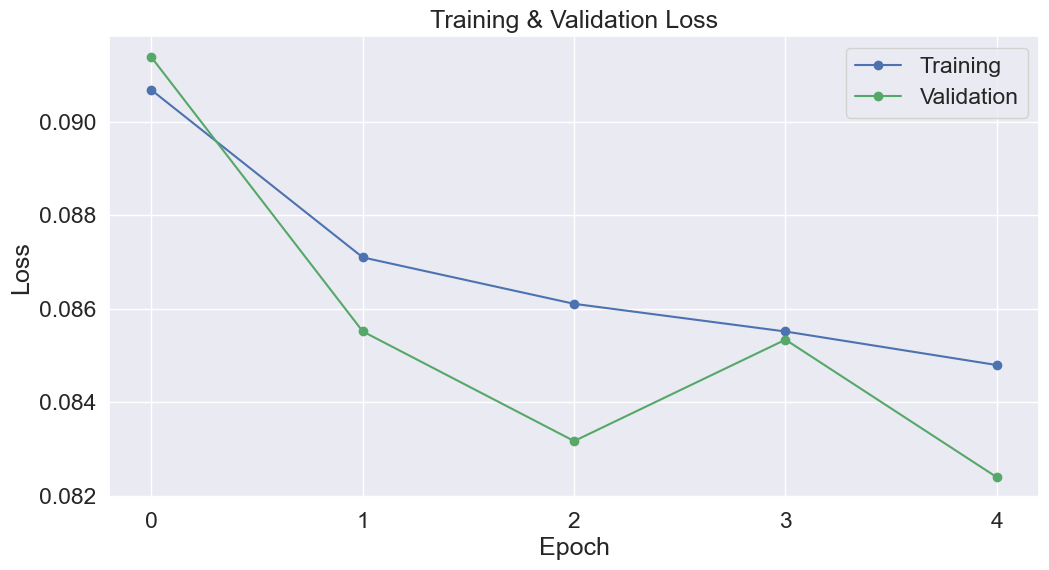

In [23]:
name_best='checkpoints/roberta_electronics_all_best.pt'
stats_name='checkpoints/roberta_electronics_all_stats.csv'
pic='pictures/roberta_electronics_all.png'
train(model, optimizer, scheduler, loss_function, epochs,
              train_dataloader,val_dataloader, name_best, stats_name, pic)

In [24]:
# load best
model, optimizer, best_epoch, best_loss = load_ckp(name_best, model, optimizer)

In [25]:
with open('results/evaluation_result_RoBERTa.txt', 'a') as f:
    f.write('\n==================roberta_electronics_all_add==================\n')
    f.write('best_epoch: ' + str(best_epoch) + '\n')
y_pred = predict(model, test_dataloader)
saved_path='results/roberta_electronics_all_add.csv'
saved_results(y_pred,y_test_electronics,X_test_electronics,saved_path)


In [26]:
with open('results/evaluation_result_RoBERTa.txt', 'a') as f:
    f.write('test evaluation:' + '\n')
evaliation(y_test_electronics, y_pred)

#RMSE:  0.2877342903305914
# PCC:  0.41425440752369
# R2:  0.18957230210959294
# NDCG:  0.9811399890344885

RMSE:  0.28849051921820473
PCC:  0.45123880785990894
NDCG:  0.982625848456166


In [27]:
del model
del optimizer
del loss_function
del scheduler
del y_pred
del name_best
del best_loss
del X_train_electronics
del X_validation_electronics
del X_test_electronics
del y_train_electronics
del y_validation_electronics
del y_test_electronics
del train_inputs
del val_inputs
del test_inputs
del train_masks
del val_masks
del test_masks
del x_train_features
del x_validation_features
del x_test_features
del y_train
del y_validation
del y_test